In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json, pickle
import argparse

import numpy as np
import pandas as pd
import torch
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from torch.utils.tensorboard import SummaryWriter

In [3]:
%load_ext autoreload
%autoreload 2

import src.utils as utils
import src.preprocess_lib as preprocess_lib

In [4]:
dataset_dir = "data"
dataset_name = "goi4_dp_full_Gipuzkoa"

In [5]:
X, raw_dates = preprocess_lib.get_full_data(dataset_dir, dataset_name, subsample_rate_user=50)

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles


In [ ]:
test_ratio = 0.2
num_test_days = int(X.shape[1] * test_ratio)
num_train_days = X.shape[1] - num_test_days

X_train_val = X[:, :-num_test_days]
X_test = X[:, -num_test_days:]

In [7]:
num_users = X.shape[0]
X_train_val = X_train_val.reshape(num_users, -1)
user_ids = np.arange(num_users)

In [8]:
# Function to split time series into chunks for each user
def create_chunks_per_user(data, user_ids, seq_len, stride):
    """
    Args:
        data (numpy.ndarray): Input data of shape (U, T).
        user_ids (numpy.ndarray): Array of user IDs of shape (U,).
        seq_len (int): Length of each sequence chunk.
        stride (int): Number of steps to move the window for the next chunk.
    Returns:
        X_chunks (numpy.ndarray): Array of chunks of shape (N, seq_len).
        y_chunks (numpy.ndarray): Array of labels of shape (N, seq_len).
    """
    X_chunks = []
    y_chunks = []
    U, T = data.shape
    for i in range(U):
        user_data = data[i]
        user_id = user_ids[i]
        # Generate chunks for this user
        for j in range(0, T - seq_len + 1, stride):
            chunk = user_data[j:j+seq_len]
            label = np.full(seq_len, user_id)
            X_chunks.append(chunk)
            y_chunks.append(label)
    X_chunks = np.array(X_chunks)
    y_chunks = np.array(y_chunks)
    return X_chunks, y_chunks

In [9]:
seq_len = 24*7*4
stride = 24*1*1

In [10]:
X_chunks, y_chunks = create_chunks_per_user(X_train_val, user_ids, seq_len=seq_len, stride=stride)

In [11]:
# Custom Dataset class for handling the data chunks
class ElectricityDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Input features of shape (N, seq_len).
            y (numpy.ndarray): Labels of shape (N, seq_len).
        """
        self.X = X
        self.y = y
            
    def __len__(self):
        return len(self.X)
            
    def __getitem__(self, idx):
        x = self.X[idx]
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)  # Shape: (seq_len, 1)
        y = self.y[idx]
        y = torch.tensor(y, dtype=torch.long)  # Shape: (seq_len,)
        return x, y

# Define the LSTM-based classifier model
class LSTMClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.5)
        self.fc = torch.nn.Linear(hidden_size, num_classes)
            
    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        out, _ = self.lstm(x)
        # Apply the fully connected layer at each time step
        out = self.fc(out)  # Shape: (batch_size, seq_len, num_classes)
        return out


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_chunks, y_chunks, test_size=0.2, random_state=42, stratify=y_chunks[:, 0])

In [13]:
nonzero_mean, nonzero_std = utils.zero_preserved_log_stats(X_train.reshape(-1)*1.0)

In [14]:
X_train_normalized = utils.zero_preserved_log_normalize(X_train*1.0, nonzero_mean, nonzero_std, log_output=True)
X_val_normalized = utils.zero_preserved_log_normalize(X_val*1.0, nonzero_mean, nonzero_std, log_output=True)

In [15]:
train_dataset = ElectricityDataset(X_train_normalized, y_train)
val_dataset = ElectricityDataset(X_val_normalized, y_val)

In [16]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=1)

In [17]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [18]:
input_size = 1
hidden_size = 512
num_layers = 3
num_epochs = 10
learning_rate = 0.001

In [19]:
model = LSTMClassifier(input_size, hidden_size, num_layers, num_users).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [74]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        # Move tensors to the configured device
        x_batch = x_batch.to(device)  # Shape: (batch_size, seq_len, 1)
        y_batch = y_batch.to(device)  # Shape: (batch_size, seq_len)

        # Forward pass
        outputs = model(x_batch)  # Shape: (batch_size, seq_len, num_classes)

        # Reshape outputs and labels for loss computation
        outputs = outputs.view(-1, num_users)  # Shape: (batch_size * seq_len, num_classes)
        y_batch = y_batch.view(-1)               # Shape: (batch_size * seq_len)

        loss = criterion(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            outputs = outputs.view(-1, num_users)
            y_batch = y_batch.view(-1)

            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    val_accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch [1/10], Loss: 0.3975, Validation Accuracy: 88.52%
Epoch [2/10], Loss: 0.3658, Validation Accuracy: 87.74%
Epoch [3/10], Loss: 0.3396, Validation Accuracy: 91.05%
Epoch [4/10], Loss: 0.3048, Validation Accuracy: 89.45%
Epoch [5/10], Loss: 0.2755, Validation Accuracy: 92.67%
Epoch [6/10], Loss: 0.2442, Validation Accuracy: 92.67%
Epoch [7/10], Loss: 0.2230, Validation Accuracy: 93.28%
Epoch [8/10], Loss: 0.2214, Validation Accuracy: 91.97%
Epoch [9/10], Loss: 0.2249, Validation Accuracy: 93.54%
Epoch [10/10], Loss: 0.1926, Validation Accuracy: 94.45%


In [75]:
torch.cuda.empty_cache()

In [76]:
def test_accuracy_over_time_full_sequence(model, X, y, sequence_lengths, device):
    """
    Test the model on full time series data without chunking and observe how accuracy improves over time.
    """
    model.eval()
    U, T = X.shape

    losses, corrects = [], []
    user_batch_size = 100
    with torch.no_grad():
        for i in range(0, U, user_batch_size):
            if i + user_batch_size > U: user_batch_size = U - i
            user_data = X[i:i+user_batch_size]
            user_id = y[i:i+user_batch_size]
            x = torch.tensor(user_data, dtype=torch.float32).unsqueeze(-1).to(device)
            logits = model(x)
            logits = logits[:, sequence_lengths-1, :]
            logprobs = torch.nn.functional.log_softmax(logits, dim=-1)

            y_true_tensor = torch.tensor(user_id, dtype=torch.long)[...,None,...].repeat_interleave(sequence_lengths.shape[0], dim=-1).to(device)

            cross_entropy_loss = torch.nn.functional.nll_loss(logprobs.reshape(-1, U), y_true_tensor.reshape(-1), reduction="none").reshape(user_batch_size, -1)
            losses.append(cross_entropy_loss.tolist())
            _, predicted = torch.max(logits.data, -1)
            corrects.append((predicted == y_true_tensor).cpu())

            print(f"User-{i+1}, Loss: {cross_entropy_loss[-1][0]:.4f}, Correct: {corrects[-1][0][-1]}")

        accuracy = np.sum(np.concatenate(corrects), axis=0) / U
    
    return accuracy, np.concatenate(losses)

In [78]:
check_freq = 24*1
sequence_lengths = np.arange(0, X_test.shape[-2]*X_test.shape[-1] + 1, check_freq)[1:]  # Every week

In [79]:
average_accuracy, individual_losses = test_accuracy_over_time_full_sequence(model, utils.zero_preserved_log_normalize(X_test.reshape(num_users,-1)*1.0,nonzero_mean,nonzero_std,log_output=True), user_ids, sequence_lengths, device)

User-1, Loss: 4.1481, Correct: True
User-101, Loss: 4.0718, Correct: True


In [80]:
sequence_lengths

array([  24,   48,   72,   96,  120,  144,  168,  192,  216,  240,  264,
        288,  312,  336,  360,  384,  408,  432,  456,  480,  504,  528,
        552,  576,  600,  624,  648,  672,  696,  720,  744,  768,  792,
        816,  840,  864,  888,  912,  936,  960,  984, 1008, 1032, 1056,
       1080, 1104, 1128, 1152, 1176, 1200, 1224, 1248, 1272, 1296, 1320,
       1344, 1368, 1392, 1416, 1440, 1464, 1488, 1512, 1536, 1560, 1584,
       1608, 1632, 1656, 1680, 1704, 1728, 1752, 1776, 1800, 1824, 1848,
       1872, 1896, 1920, 1944, 1968, 1992, 2016, 2040, 2064, 2088, 2112,
       2136, 2160, 2184, 2208, 2232, 2256, 2280, 2304, 2328, 2352, 2376,
       2400, 2424, 2448, 2472, 2496, 2520, 2544, 2568, 2592, 2616])

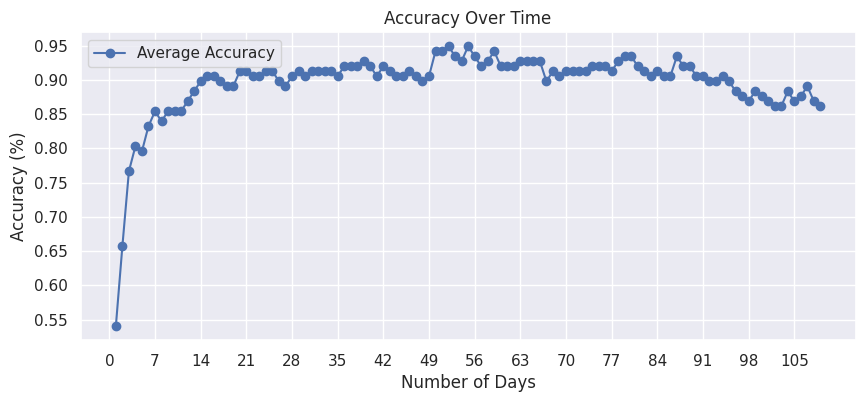

In [82]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(sequence_lengths//24, average_accuracy, marker='o', label='Average Accuracy')
ax.set_xticks(np.arange(0, sequence_lengths[-1]//24+1, 7))
ax.set_title('Accuracy Over Time')
ax.set_xlabel('Number of Days')
ax.set_ylabel('Accuracy (%)')
ax.legend()
plt.show()

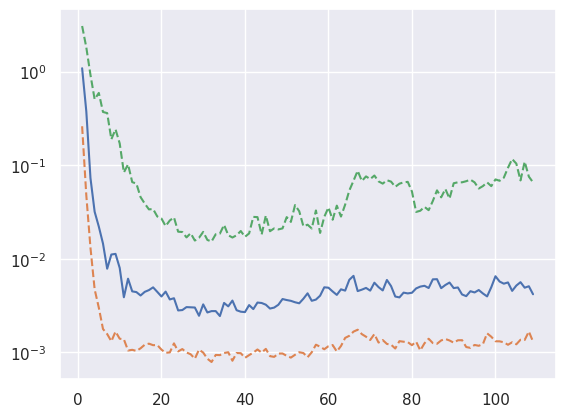

In [83]:
plt.plot(sequence_lengths//check_freq, np.median(individual_losses, axis=0))
plt.plot(sequence_lengths//check_freq, np.quantile(individual_losses, 0.25, axis=0), linestyle='--')
plt.plot(sequence_lengths//check_freq, np.quantile(individual_losses, 0.75, axis=0), linestyle='--')

plt.yscale('log')

<Axes: >

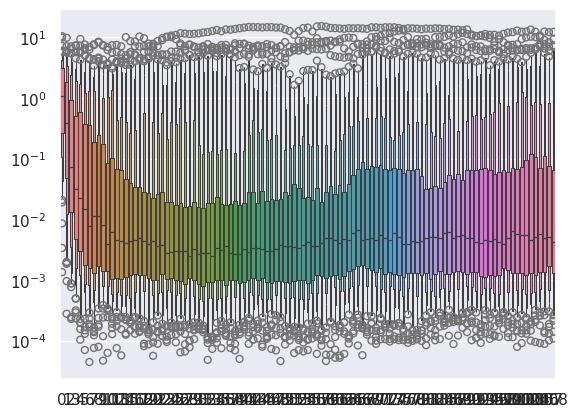

In [84]:
sns.boxenplot(individual_losses, log_scale=True)